## Task A: optimize a region

In [ ]:
import pandas as pd
import numpy as np  
import pypsa 
import warnings
warnings.filterwarnings("ignore")

# Import datasets
country = "FIN"
year = 2015

demand = pd.read_csv("electricity_demand.csv", sep=";", index_col=0, parse_dates=True)
demand = demand[country].loc[demand.index.year == year]

onshore = pd.read_csv("onshore_wind_1979-2017.csv", sep=";", index_col=0, parse_dates=True)
onshore = onshore[country].loc[onshore.index.year == year]

solar = pd.read_csv("pv_optimal.csv", sep=";", index_col=0, parse_dates=True)
solar = solar[country].loc[solar.index.year == year]

heat = pd.read_csv("heat_demand.csv", sep=";", index_col=0, parse_dates=True)
heat = heat[country].loc[solar.index.year == year]

snapshots = demand.index




In [115]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_2030.csv"
costs = pd.read_csv(url, index_col=[0, 1])

# Convert costs to MW
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

# Define default values for missing parameters 
defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

# Compute marginal costs
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

# Compute capital costs
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

wind_capital = costs.at["onwind", "capital_cost"] #EUR/MW/a
wind_marginal = costs.at["onwind", "marginal_cost"] #EUR/MWh
solar_capital = costs.at["solar", "capital_cost"] #EUR/MW/a
solar_marginal = costs.at["solar", "marginal_cost"] #EUR/MWh
gas_capital = costs.at["OCGT", "capital_cost"] #EUR/MW/a
gas_marginal = costs.at["OCGT", "marginal_cost"] #EUR/MWh
nuclear_capital = costs.at["nuclear", "capital_cost"] #EUR/MW/a
nuclear_marginal = costs.at["nuclear", "marginal_cost"] #EUR/MWh
pumped_hydro_capital = costs.at["Pumped-Storage-Hydro-store", "capital_cost"] 
pumped_hydro_marginal = costs.at["Pumped-Storage-Hydro-store", "marginal_cost"] #EUR/MWh

In [132]:
network = pypsa.Network()
network.set_snapshots(snapshots)


# Add buses
network.add("Bus", "FIN_el")
network.add("Bus", "FIN_hydro")
# network.add("Bus", "FIN_gas")

# Add carriers
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "nuclear",
    "Pumped-Storage-Hydro-store",
]

colors = ["dodgerblue", "gold", "indianred","yellow-green", "brown"]

for i in range(len(carriers)):
    network.add("Carrier", carriers[i], co2_emissions=costs.at[carriers[i], "CO2 intensity"], color=colors[i])


# Add loads
network.add("Load", "FIN_el_load", bus="FIN_el", p_set=demand.values)


# Add generators
network.add("Generator", "FIN_onshore_wind", bus="FIN_el", p_nom_extendable=True, p_max_pu=onshore.values, marginal_cost=wind_marginal, capital_cost=wind_capital)
network.add("Generator", "FIN_solar", bus="FIN_el", p_nom_extendable=True, p_max_pu=solar.values, marginal_cost=solar_marginal, capital_cost=solar_capital)
network.add("Generator", "FIN_OCGT", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=gas_marginal, efficiency = costs.at["OCGT","efficiency"], capital_cost=gas_capital)
network.add("Generator", "FIN_nuclear", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=nuclear_marginal, efficiency = costs.at["nuclear","efficiency"], capital_cost=nuclear_capital)

# Add hydro
network.add("Link", "FIN_hydro", bus0="FIN_hydro", bus1="FIN_el",
            p_nom_extendable=True, efficiency=1, p_max_pu=1, p_min_pu=-1, capital_cost=0)

# Add hydro storage
network.add("StorageUnit", "FIN_pumped_hydro", bus="FIN_hydro", efficiency_store=0.86, efficiency_dispatch=0.86, capital_cost=pumped_hydro_capital, marginal_cost=pumped_hydro_marginal,
            p_nom_extendable=True,
            cyclic_state_of_charge=True) 


# Optimize
network.optimize(solver_name='gurobi', solver_options={'outputflag': 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-06


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 39.68it/s]
INFO:linopy.io: Writing time: 1.64s


Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-mgijnqy4.lp


INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-mgijnqy4.lp


Reading time = 0.43 seconds


INFO:gurobipy:Reading time = 0.43 seconds


obj: 166446 rows, 70086 columns, 320097 nonzeros


INFO:gurobipy:obj: 166446 rows, 70086 columns, 320097 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70086 primals, 166446 duals
Objective: 5.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

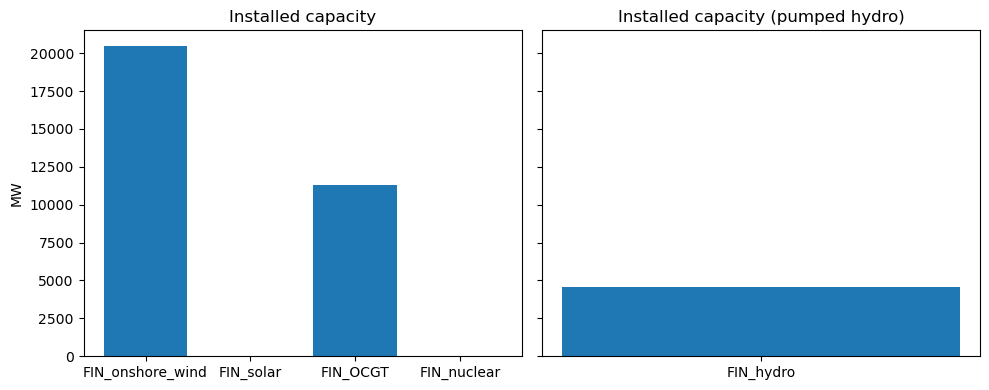

In [155]:
gen_cap = network.generators.p_nom_opt
gen_prod = network.generators_t.p
links_cap = network.links.p_nom_opt
links_prod = network.links_t.p0

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)

ax[0].bar(gen_cap.index, gen_cap.values)
ax[0].set_title("Installed capacity")
ax[0].set_ylabel("MW")
# ax[0].xticks(rotation=45)

ax[1].bar(links_cap.index, links_cap.values)
ax[1].set_title("Installed capacity (pumped hydro)")
# ax[1].set_ylabel("MW")
# ax[1].set_xticks(rotation=45)
plt.tight_layout()

In [135]:
network.storage_units.p_nom_opt

StorageUnit
FIN_pumped_hydro    5906.212008
Name: p_nom_opt, dtype: float64

In [136]:
network.links.p_nom_opt

Link
FIN_hydro    4593.16002
Name: p_nom_opt, dtype: float64

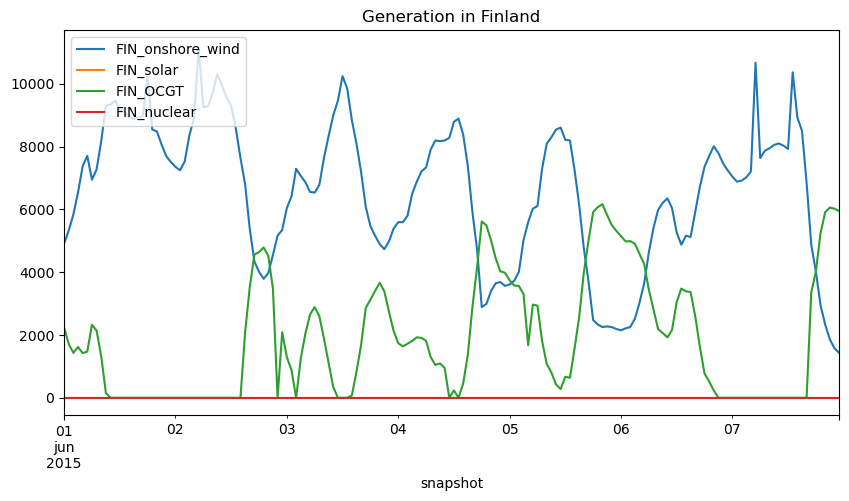

In [ ]:
# Plot a week of generation


gen_prod.loc["2015-06-01":"2015-06-07"].plot(title="Generation in Finland", figsize=(10,5));
# demand.loc["2015-01-01":"2015-01-07"].plot(label="Demand", color="black", linewidth=2, alpha=0.7);
plt.legend(loc="upper left")
plt.show()

<Axes: xlabel='snapshot'>

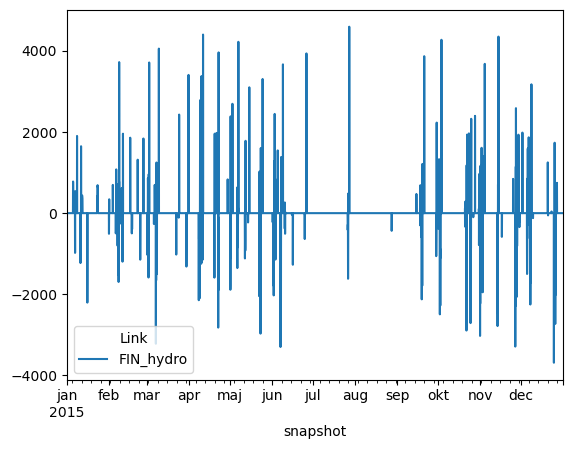

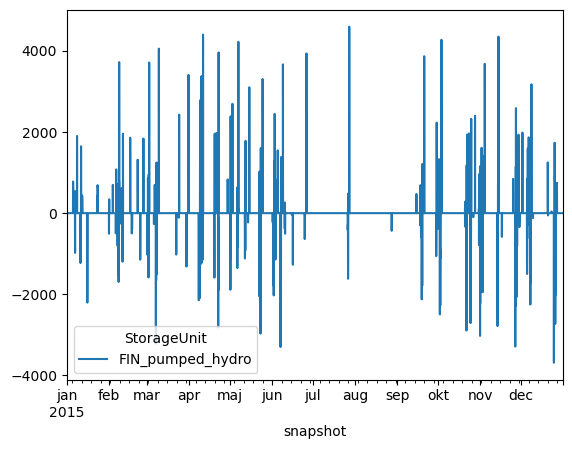

In [188]:
network.links_t.p0.plot()
(network.storage_units_t.p_dispatch-network.storage_units_t.p_store).plot()


Text(0.5, 1.07, 'Electricity mix')

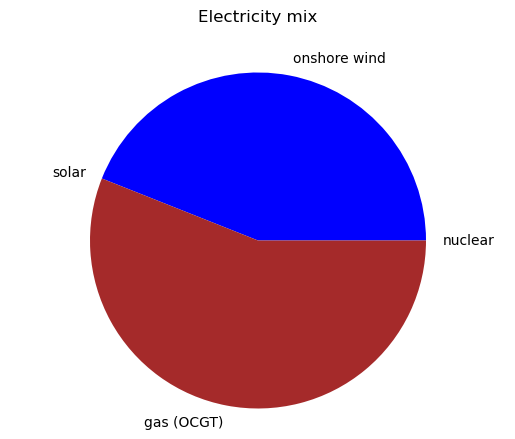

In [ ]:
# Plot electricity mix
labels = ['onshore wind',
          'solar',
          'gas (OCGT)',
          "nuclear"]
sizes = [network.generators_t.p['FIN_onshore_wind'].sum(),
         network.generators_t.p['FIN_solar'].sum(),
         network.generators_t.p['FIN_OCGT'].sum(),
         network.generators_t.p['FIN_nuclear'].sum(),
         network.generators_t.p['FIN_nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [164]:
sizes

[np.float64(36316012.305658855),
 np.float64(0.0),
 np.float64(46250791.27312313),
 np.float64(0.0)]